In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter
import seaborn as sns

In [13]:
df_mathces = pd.read_csv('./high_confidence_matches.csv')
df_meetings = pd.read_csv('./data/meetings.csv')
df_register = pd.read_excel(
    r"D:\OneDrive\UFPR\00.PPGCP\00. Doutorado\Tese\Base de dados\Transparency register\Organisations in Transparency Register-2024-JAN.xls"
)

In [16]:
df_combined = df_mathces.merge(df_register, left_on='matched_organization', right_on='Name')

In [17]:
cat_mapper = {
    "Non-governmental organisations, platforms and networks and similar": "NGOs",
    "Trade and business associations": "Business",
    "Companies & groups": "Business",
    "Other organisations, public or mixed entities": "Other",
    "Trade unions and professional associations": "Other",
    "Self-employed individuals": "Other",
    "Think tanks and research institutions": "Other",
    "Professional consultancies": "Other",
    "Academic institutions": "Other",
    "Associations and networks of public authorities": "Other",
    "Organisations representing churches and religious communities": "Other",
    "Law firms": "Other",
    "Entities, offices or networks established by third countries": "Other",
}


df_combined["month"] = df_combined["meeting_date"].apply(lambda x: "-".join(x.split("-")[:2]))
df_combined["cat_mapped"] = df_combined["Category of registration"].apply(
    lambda x: cat_mapper.get(x)
)

In [18]:
df_g_n_meetings = (
    df_combined[["month"]]
    .join(pd.get_dummies(df_combined[["cat_mapped"]]))
    .groupby("month")
    .sum()
    .reset_index()
)

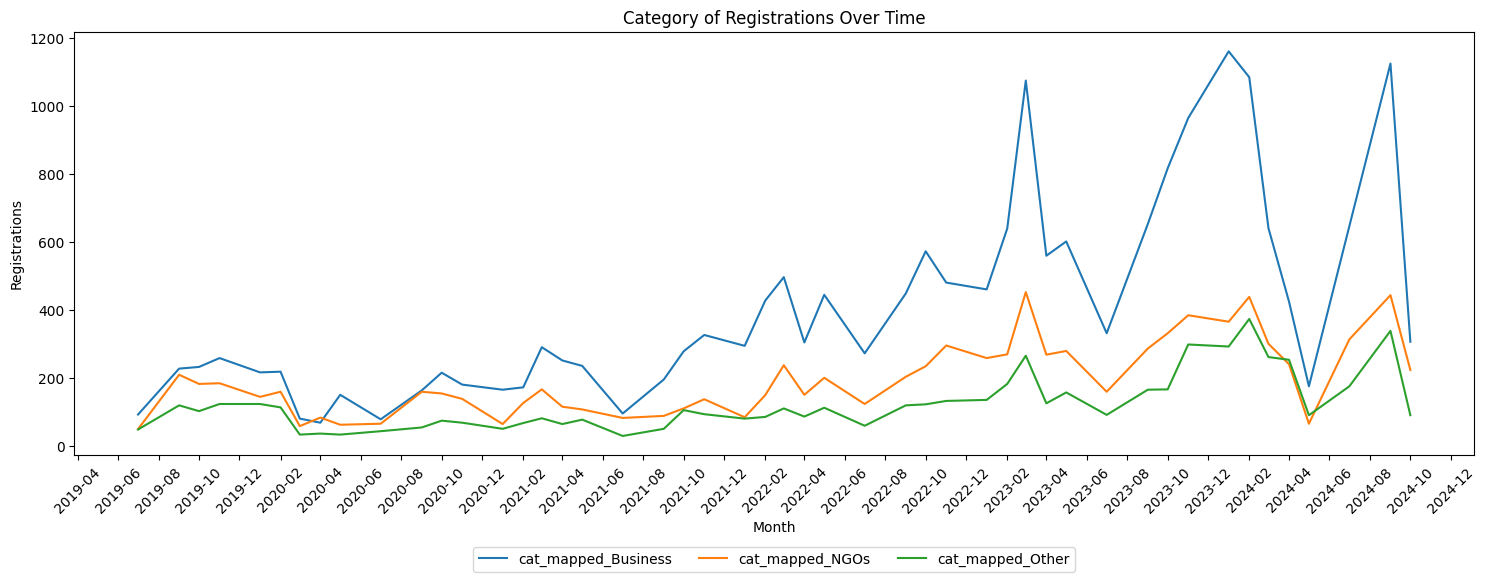

In [21]:
# Convert 'month' column to datetime
df = df_g_n_meetings.copy()
df["month"] = pd.to_datetime(df["month"])

# Set 'month' as the index for better plotting
df.set_index("month", inplace=True)

df = df[(df.index.month != 8) & (df.index.month != 12) & (df.index.month != 6)]
# Plot each column
plt.figure(figsize=(15, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# Add labels and title
plt.xlabel("Month")
plt.ylabel("Registrations")
plt.title("Category of Registrations Over Time")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Set legend at the bottom
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
df_combined[["member_id", "member_capacity", "title"]].groupby(
    ["member_id", "member_capacity"]
).count().sort_values('title', ascending=False)

,,title
member_id,member_capacity,
96761.0,Shadow rapporteur,510
96711.0,Member,481
1927.0,Rapporteur,448
28226.0,Member,381
96833.0,Member,311
...,...,...
229519.0,Rapporteur for opinion,1
197610.0,Member,1
197611.0,Member,1


# Analisar reuniões por parlamentar

In [32]:
df_final = df_combined.pivot_table(index='member_id', columns="cat_mapped", aggfunc='size', fill_value=0)
df_final['Total'] = df_final.sum(axis=1)
df_final.sort_values('Total', ascending=False)


cat_mapped,Business,NGOs,Other,Total
member_id,,,,
96761.0,482,86,91,659
1927.0,434,83,81,598
197515.0,318,62,107,487
96711.0,288,148,48,484
185619.0,245,167,51,463
...,...,...,...,...
257033.0,0,1,0,1
257031.0,1,0,0,1
1854.0,1,0,0,1


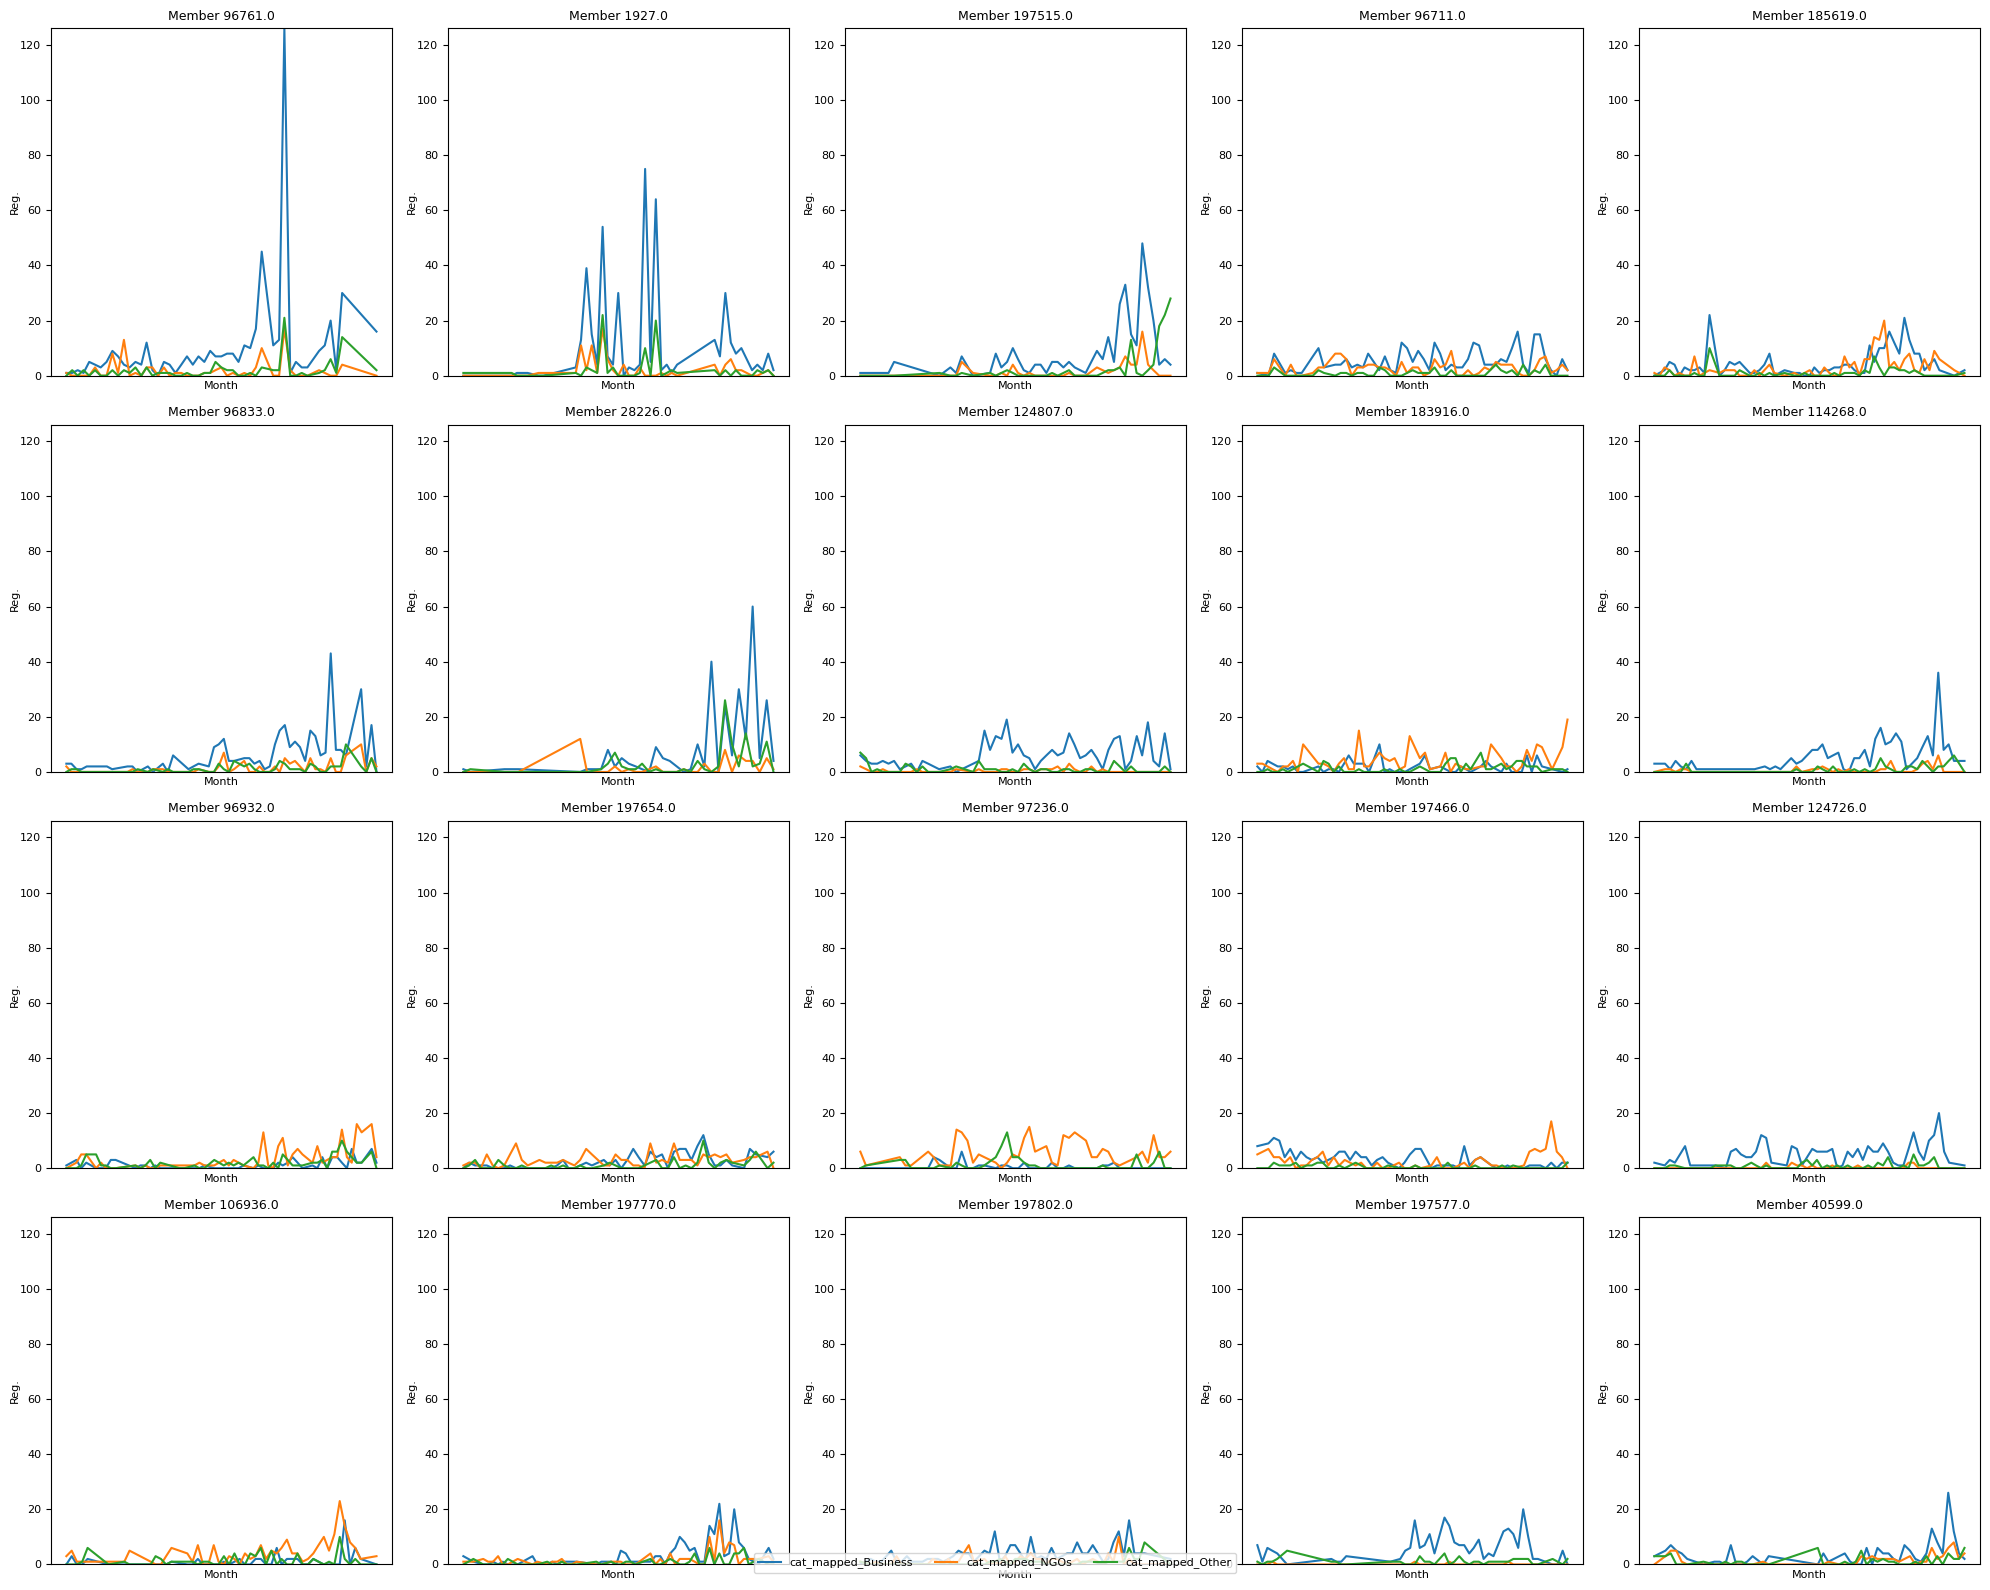

In [40]:
def plot_member_meetings(df_combined, N, ncols=5):
    # Calculate number of rows needed
    nrows = (N + ncols - 1) // ncols

    # Get top N members 
    top_n = df_final.sort_values('Total', ascending=False).head(N).index
    
    # Create figure with reduced spacing
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    
    # Flatten axes array for easier iteration
    axes_flat = axes.flatten()

    # Find global y-axis limits
    y_max = 0
    y_min = float('inf')
    for member in top_n:
        df = df_combined[df_combined['member_id'] == member].copy()
        df = (
            df[["month"]]
            .join(pd.get_dummies(df[["cat_mapped"]]))
            .groupby("month")
            .sum()
            .reset_index()
        )
        df["month"] = pd.to_datetime(df["month"])
        df.set_index("month", inplace=True)
        y_max = max(y_max, df.max().max())
        y_min = min(y_min, df.min().min())

    for idx, member in enumerate(top_n):
        df = df_combined[df_combined['member_id'] == member].copy()
        df = (
            df[["month"]]
            .join(pd.get_dummies(df[["cat_mapped"]]))
            .groupby("month")
            .sum()
            .reset_index()
        )

        df["month"] = pd.to_datetime(df["month"])
        df.set_index("month", inplace=True)

        ax = axes_flat[idx]
        
        # Plot each column
        for column in df.columns:
            ax.plot(df.index, df[column], label=column if idx == 0 else "")

        # Add labels and title with smaller font
        ax.set_xlabel("Month", fontsize=8)
        ax.set_ylabel("Reg.", fontsize=8, labelpad=0)
        ax.set_title(f"Member {member}", fontsize=9)

        # Format x-axis
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        
        # Remove x-axis ticks
        ax.set_xticks([])
        
        # Set y-axis limits and reduce tick label size
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis='y', labelsize=8)
    
    # Hide empty subplots
    for idx in range(len(top_n), len(axes_flat)):
        axes_flat[idx].set_visible(False)

    # Add single legend at the bottom of the figure
    fig.legend(bbox_to_anchor=(0.5, 0.02), loc='center', ncol=3, fontsize=8)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_member_meetings(df_combined, 20)  # Plot top 20 members